In [ ]:
### Connecting with google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# ---------------------------
# STEP 1: Install required libraries
# ---------------------------

# We use specific versions for reproducibility but prefer latest versions for stability.
# - `transformers`: For loading Llama 3.2 model and tokenizer.
# - `datasets`: For loading and preprocessing QnA datasets (e.g., SQuAD, Alpaca).
# - `peft`: For LoRA (Low-Rank Adaptation) to fine-tune efficiently.
# - `bitsandbytes`: For 4-bit/8-bit quantization to reduce VRAM usage.
# - `trl`: For supervised fine-tuning with custom loss functions.
# - `accelerate`: For distributed training and mixed precision.
# Use `!pip` in Colab; for local runs, use `pip install` in your terminal.

!pip -q install matplotlib seaborn -U
# Install required libraries for fine-tuning Llama-3.2 with transformers, quantization, and PEFT on Colab
!pip install transformers==4.45.2
!pip install datasets==3.0.1
!pip install peft==0.13.2
!pip install bitsandbytes==0.44.0
!pip install accelerate==0.34.2
!pip install torch==2.4.1
!pip install trl==0.11.4
!pip install rouge-score
!pip install nltk
!pip install bert-score

# Verify imports + CUDA
import torch, transformers, trl, peft, bitsandbytes as bnb, accelerate, datasets, huggingface_hub
print("torch:", torch.__version__, "| cuda:", torch.cuda.is_available(), "| capability:", torch.cuda.get_device_capability() if torch.cuda.is_available() else None)
print("transformers:", transformers.__version__)
print("trl:", trl.__version__)
print("peft:", peft.__version__)
print("bitsandbytes:", bnb.__version__)
print("accelerate:", accelerate.__version__)
print("datasets:", datasets.__version__)

# Quick check: can bitsandbytes see CUDA?
import os
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES", "not set"))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 112.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.0
    Uninstalling tokenizers-0.22.0:
      Successfully uninstalled tokenizers-0.22.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 22.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting un

In [ ]:
# ---------------------------
# STEP 2: The Hugging Face Hub requires authentication if you want to:
# ---------------------------

#   - Download gated models (like LLaMA, Mistral, etc.)
#   - Push your trained models back to your HF account
#   - Access private datasets
# Load your Hugging Face access token from a JSON file stored in Google Drive
# Example of HF_token.json:
# {
#   "llm_token": "hf_xxxxxxxxxxxxxxxxxxxxxxxx"
# }


from huggingface_hub import login
import json
with open('/content/drive/MyDrive/LLM_training/QuestionAnswer/HF_token.json') as f:
    key  = json.load(f)
login(token=key["llm_token"])

In [ ]:
# ---------------------------
# STEP 3: Set Random Seed for Reproducibility
# ---------------------------

# Why do this?
# - Deep learning training is *stochastic* (randomness is involved in weight init, data shuffling, dropout, etc.)
# - By fixing a seed, we ensure that experiments can be repeated and results are consistent
# - Especially important when debugging or comparing different hyperparameters

import random
import torch

SEED = 42

def seed_everything(seed: int):
    random.seed(seed)
    # np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(SEED)

In [ ]:

# ---------------------------
# STEP 4: Load and Inspect Dataset
# ---------------------------

# We use Hugging Face Datasets library to load the QnA dataset.
# In this case: "virattt/financial-qa-10K"
#   - This dataset contains financial context, questions, and answers
#   - We'll fine-tune LLaMA to answer questions based on context

from datasets import load_dataset
import pandas as pd

# 1) Load the dataset from Hugging Face
dataset = load_dataset("virattt/financial-qa-10K") ### https://huggingface.co/datasets/virattt/financial-qa-10K
print(dataset)  # Shows available splits and sizes

# 2) Convert to DataFrame (assuming it only has 'train' split)
split_name = list(dataset.keys())[0]  # e.g., 'train'
df = dataset[split_name].to_pandas()

# 3) Basic info
print("\nDataFrame shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# 4) Preview the first few rows
print("\nSample rows:")
df.head(3)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/419 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context', 'ticker', 'filing'],
        num_rows: 7000
    })
})

DataFrame shape: (7000, 5)

Columns: ['question', 'answer', 'context', 'ticker', 'filing']

Sample rows:


,question,answer,context,ticker,filing
0,What area did NVIDIA initially focus on before...,NVIDIA initially focused on PC graphics.,"Since our original focus on PC graphics, we ha...",NVDA,2023_10K
1,What are some of the recent applications of GP...,Recent applications of GPU-powered deep learni...,Some of the most recent applications of GPU-po...,NVDA,2023_10K
2,What significant invention did NVIDIA create i...,NVIDIA invented the GPU in 1999.,Our invention of the GPU in 1999 defined moder...,NVDA,2023_10K


In [ ]:
# df_or = df.copy()


In [ ]:
# df.head()

In [ ]:
df.columns

Index(['question', 'answer', 'context', 'ticker', 'filing'], dtype='object')

### IMP Parameters:

In [ ]:
# MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"
MODEL_ID = "meta-llama/Llama-3.2-1B-Instruct" ### https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct
# MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"

In [ ]:
# ---------------------------
# STEP 5: Download Base Model from Hugging Face
# ---------------------------

# Why do this?
# - Models like LLaMA are large, and downloading them each run wastes time & bandwidth.
# - By caching them into Google Drive, we can:
#     1) Reuse across Colab sessions
#     2) Avoid repeated downloads
#     3) Keep a fixed version for reproducibility


### download the model once:
from huggingface_hub import snapshot_download

# where to save on Drive
local_model_dir = f"/content/drive/MyDrive/LLM_training/HF_models/{MODEL_ID.split('/')[-1]}"

# make sure path exists
os.makedirs(local_model_dir, exist_ok=True)

# Download the model snapshot from Hugging Face Hub
# - repo_id: Which model to download (from Hugging Face)
# - local_dir: Path where files are stored
# - local_dir_use_symlinks=False: Avoids symlink issues on Google Drive
# - resume_download=True: Continues from previous partial downloads
# download (resumes if interrupted)
snapshot_download(
    repo_id=MODEL_ID,
    local_dir=local_model_dir,
    local_dir_use_symlinks=False,   # avoids symlink issues on Drive
    resume_download=True            # saves time if rerun
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

'/content/drive/MyDrive/LLM_training/HF_models/Llama-3.2-1B-Instruct'

## Token vs Embedding:

- TOKEN - A token is the smallest unit of text that a language model processes, such as a word, subword, punctuation mark, or special character. Tokens are the output of the tokenization process and are mapped to numerical IDs based on the model’s vocabulary.
- EMBEDDING -  An embedding is a dense vector representation of a token (or sequence of tokens) in a high-dimensional space.Embeddings capture semantic meaning, so tokens with similar meanings (e.g., "cat" and "kitten") have similar vectors.
- https://www.youtube.com/watch?v=7xTGNNLPyMI&t=11120s : best for tokenization understanding


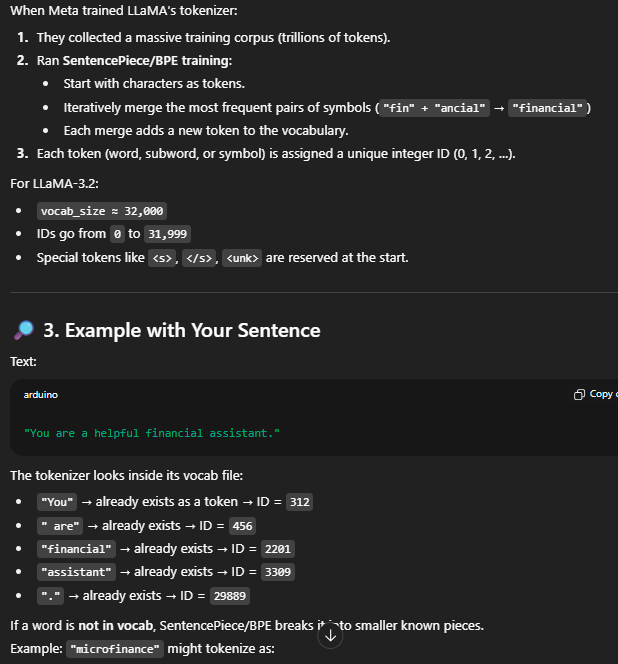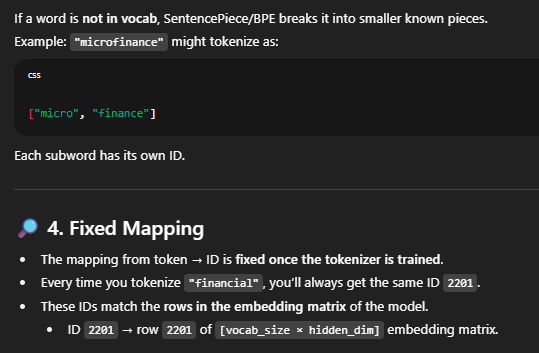

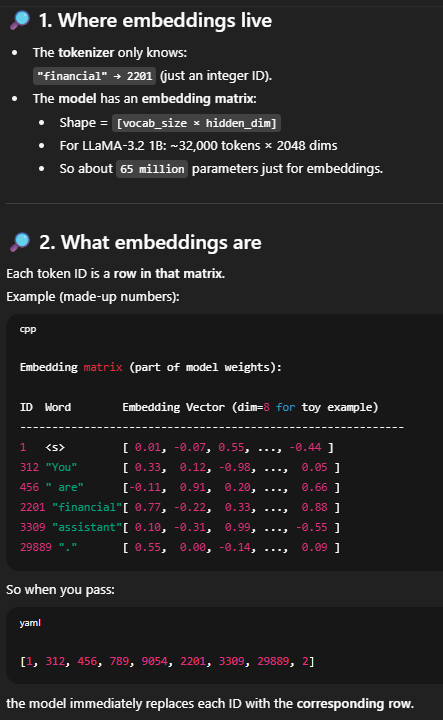

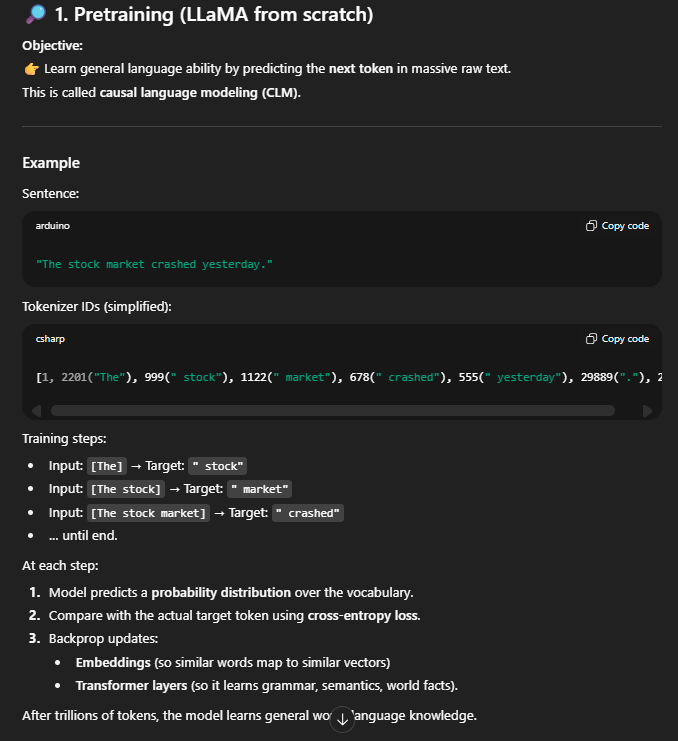

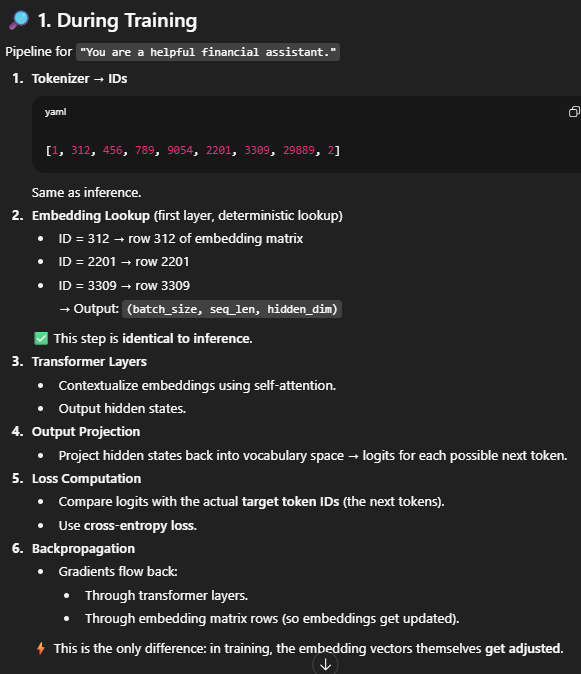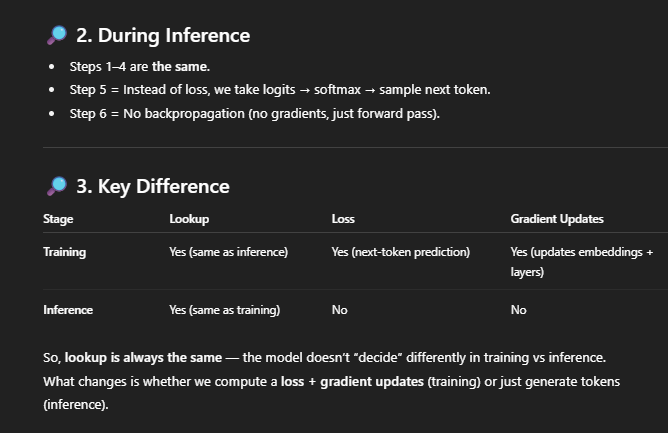

### creating tokens:

In [ ]:
# ---------------------------
# STEP 6: Load and Configure Tokenizer
# ---------------------------

# Why this step?
# - The tokenizer converts text ↔ tokens (IDs) which the model understands.
# - For LLaMA and similar models, we often need to adjust padding behavior
#   because these models do not have a dedicated <pad> token by default.

# 1) Load tokenizer
from transformers import AutoTokenizer
# tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True) ### to download the tokenizer from the hf repo

tok = AutoTokenizer.from_pretrained(local_model_dir, use_fast=True) ### to load the tokenizer from the downloaded files

tok.pad_token = tok.eos_token ### llama does not have a <pad> token. its a general practice to add eos_token as pad token
tok.pad_token_id = tok.eos_token_id
tok.padding_side = "right"   # better for causal LM fine-tuning


# 2) Show special tokens + the built-in chat template
print("=== Special tokens ===")
print("BOS:", tok.bos_token, repr(tok.bos_token))   # Beginning-of-sequence
print("EOS:", tok.eos_token, repr(tok.eos_token))   # End-of-sequence
print("UNK:", tok.unk_token, repr(tok.unk_token))   # Unknown token
print("PAD:", tok.pad_token, repr(tok.pad_token))   # Padding token
print("\n=== Chat template (tokenizer.chat_template) ===")
# print(tok.chat_template)  # Jinja template that apply_chat_template uses under the hood

=== Special tokens ===
BOS: <|begin_of_text|> '<|begin_of_text|>'
EOS: <|eot_id|> '<|eot_id|>'
UNK: None None
PAD: <|eot_id|> '<|eot_id|>'

=== Chat template (tokenizer.chat_template) ===


In [ ]:
# ---------------------------
# STEP 7: Format Dataset into LLaMA Chat Style
# ---------------------------

# Why this step?
# - LLaMA-3.2 (and similar chat models) expect data in a structured *chat format*:
#     [system message] + [user message] → [assistant response]
# - Using the built-in `apply_chat_template` ensures our fine-tuning data matches
#   the exact format the model was pretrained on.
# - This helps the model learn the QnA task properly.

# Define system prompt
SYSTEM_PROMPT = (
    "You are a helpful financial assistant. "
    "Answer strictly from the provided context. "
    "If the answer is not present in the context, reply: \"I don't know.\""
)

# Formatting function for Llama-3.2 chat
def format_llama_chat(context, question, answer):
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": f"Context: {context}\n\nQuestion: {question}"},
        {"role": "assistant", "content": answer},
    ]
    return tok.apply_chat_template(messages, add_generation_prompt=False, tokenize=False)

# --- Example with first row ---
sample_row = df.iloc[0]
example_text = format_llama_chat(sample_row["context"], sample_row["question"], sample_row["answer"])
print("========= Raw data ============\n")
print(sample_row["context"],"\n", sample_row["question"],"\n", sample_row["answer"])
print("=== Example formatted text ===\n")
print(example_text)

========= Raw data ============

Since our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields. 
 What area did NVIDIA initially focus on before expanding to other computationally intensive fields? 
 NVIDIA initially focused on PC graphics.
=== Example formatted text ===

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 28 Sep 2025

You are a helpful financial assistant. Answer strictly from the provided context. If the answer is not present in the context, reply: "I don't know."<|eot_id|><|start_header_id|>user<|end_header_id|>

Context: Since our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields.

Question: What area did NVIDIA initially focus on before expanding to other computationally intensive fields?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

NVIDIA initially focused on PC 

In [ ]:
# ---------------------------
# STEP 8: Apply Chat Formatting to Entire Dataset
# ---------------------------

# Why this step?
# - In Step 7, we wrote a function to format a single row into LLaMA chat style.
# - Now, we apply it to the entire DataFrame to create a new "text" column.
# - This "text" column will be used as the input for fine-tuning.

# Apply formatting function to each row
# - For every row, combine (context, question, answer) → LLaMA chat format
# - Store result in a new "text" column

# --- Apply to full DataFrame ---
df = df.assign(text=df.apply(lambda row: format_llama_chat(row["context"], row["question"], row["answer"]), axis=1))[
    ["context", "question", "answer", "text"]
]

print("\n=== DataFrame preview ===")
df.head()


=== DataFrame preview ===


,context,question,answer,text
0,"Since our original focus on PC graphics, we ha...",What area did NVIDIA initially focus on before...,NVIDIA initially focused on PC graphics.,<|begin_of_text|><|start_header_id|>system<|en...
1,Some of the most recent applications of GPU-po...,What are some of the recent applications of GP...,Recent applications of GPU-powered deep learni...,<|begin_of_text|><|start_header_id|>system<|en...
2,Our invention of the GPU in 1999 defined moder...,What significant invention did NVIDIA create i...,NVIDIA invented the GPU in 1999.,<|begin_of_text|><|start_header_id|>system<|en...
3,"NVIDIA has a platform strategy, bringing toget...",How does NVIDIA's platform strategy contribute...,NVIDIA's platform strategy brings together har...,<|begin_of_text|><|start_header_id|>system<|en...
4,With our introduction of the CUDA programming ...,What does NVIDIA's CUDA programming model enable?,NVIDIA's CUDA programming model opened the par...,<|begin_of_text|><|start_header_id|>system<|en...


Max length: 1134
95th percentile: 238
99th percentile: 307
Mean length: 160


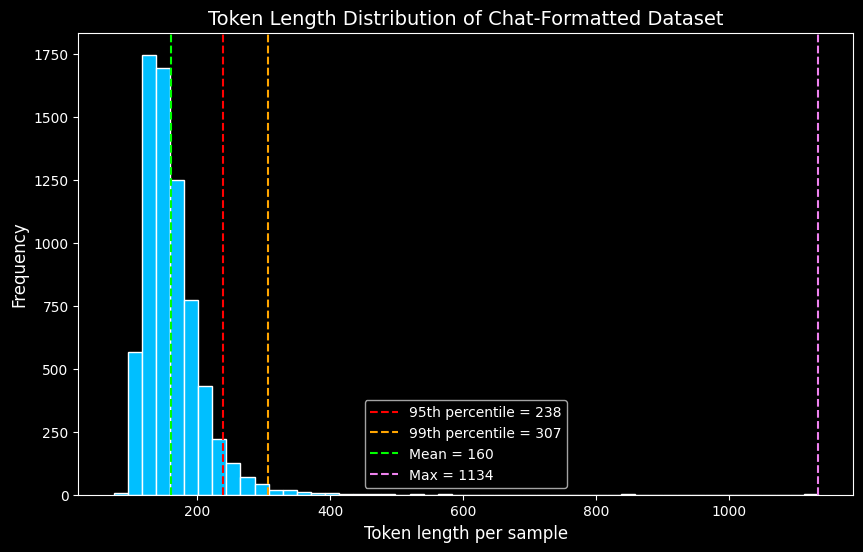

✅ Chosen MAX_SEQ_LENGTH = 307


In [ ]:
# ---------------------------
# STEP 8.5: Analyze Token Length Distribution (Dark Mode Plot)
# ---------------------------

import numpy as np
import matplotlib.pyplot as plt

# Compute token lengths for all samples
lengths = [len(tok(text)["input_ids"]) for text in df["text"]]

# Statistics
max_len = max(lengths)
p95 = int(np.percentile(lengths, 95))
p99 = int(np.percentile(lengths, 99))
mean_len = int(np.mean(lengths))

print(f"Max length: {max_len}")
print(f"95th percentile: {p95}")
print(f"99th percentile: {p99}")
print(f"Mean length: {mean_len}")

# Dark mode style
plt.style.use("dark_background")

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, color="deepskyblue", edgecolor="white")
plt.axvline(p95, color="red", linestyle="--", label=f"95th percentile = {p95}")
plt.axvline(p99, color="orange", linestyle="--", label=f"99th percentile = {p99}")
plt.axvline(mean_len, color="lime", linestyle="--", label=f"Mean = {mean_len}")
plt.axvline(max_len, color="violet", linestyle="--", label=f"Max = {max_len}")

plt.title("Token Length Distribution of Chat-Formatted Dataset", fontsize=14)
plt.xlabel("Token length per sample", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()

# Use 95th percentile as MAX_SEQ_LENGTH (good tradeoff for GPU memory vs coverage)
MAX_SEQ_LENGTH = p99
print(f"✅ Chosen MAX_SEQ_LENGTH = {MAX_SEQ_LENGTH}")


In [ ]:
# ---------------------------
# STEP 9: Convert DataFrame to HF Dataset & Tokenize
# ---------------------------

# Why this step?
# - Hugging Face's Trainer / SFTTrainer expects a Dataset object, not a Pandas DataFrame.
# - We need to tokenize text into input IDs so the model can process it.
# - Also, we split into training and validation sets for monitoring.

from datasets import Dataset
import os

# Convert DataFrame to Hugging Face Dataset
formatted_dataset = Dataset.from_pandas(df[['text']])

# Tokenize dataset
def tokenize_function(examples):
    return tok(
        examples['text'],          # our chat-formatted string
        padding="max_length",      # pad all to fixed length (useful for batching)
        truncation=True,           # truncate sequences longer than max_length
        max_length=MAX_SEQ_LENGTH,           # adjust based on GPU memory / dataset needs
        return_tensors="pt"        # return as PyTorch tensors
    )

tokenized_dataset = formatted_dataset.map(tokenize_function, batched=True)

# Split into train and validation (90% train, 10% validation)
train_test_split = tokenized_dataset.train_test_split(test_size=0.25, seed=42)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

# Print sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(eval_dataset)}")

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Training dataset size: 5250
Validation dataset size: 1750


### see tokens:

In [ ]:
# Get one example from training dataset
sample = train_dataset[0]  # First example
raw_text = sample['text']
input_ids = sample['input_ids']

# Decode tokens back to text
decoded_text = tok.decode(input_ids, skip_special_tokens=False)

# Print results
print("=== Raw Text ===")
print(raw_text)
print("\n=== Tokenized Input IDs ===")
print(input_ids)
print("\n=== Decoded Text ===")
print(decoded_text)

# Optional: Show individual tokens
tokens = tok.convert_ids_to_tokens(input_ids)
print("\n=== Individual Tokens ===")
print(tokens)

=== Raw Text ===
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 28 Sep 2025

You are a helpful financial assistant. Answer strictly from the provided context. If the answer is not present in the context, reply: "I don't know."<|eot_id|><|start_header_id|>user<|end_header_id|>

Context: For fiscal 2023, Nike Brand apparel finished goods were manufactured by 55 contract manufacturers, and the largest single finished goods apparel factory accounted for about 8% of the total Nike Brand apparel production.

Question: How many contract manufacturers did Nike have for apparel production in fiscal 2023, and what was the percentage of production from the largest factory?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

In fiscal 2023, Nike had 55 contract manufacturers for apparel production, and the largest single finished goods apparel factory accounted for approximately 8% of total Nike Brand apparel production.<|eot_id|>

In [ ]:
# train_dataset[0]

### Loading basemodel in 4 bit

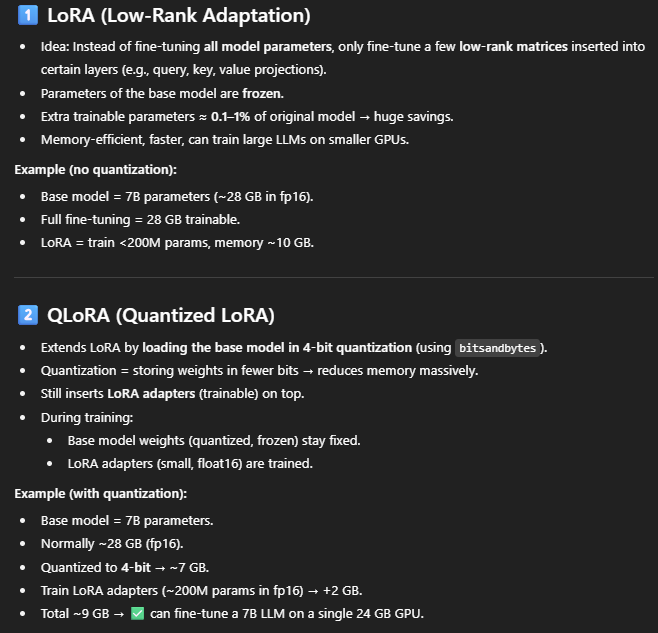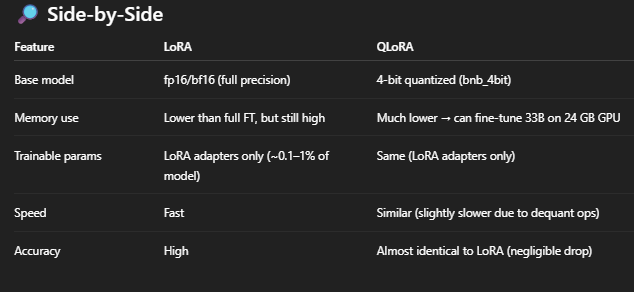

How 4bit and bfloat16 are used during training and inferencing

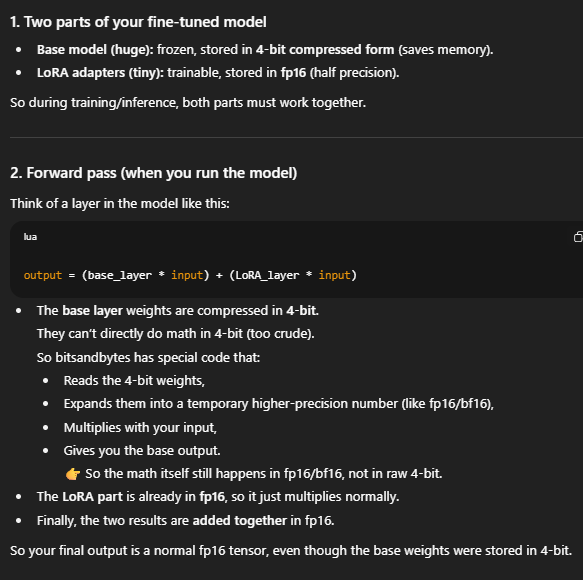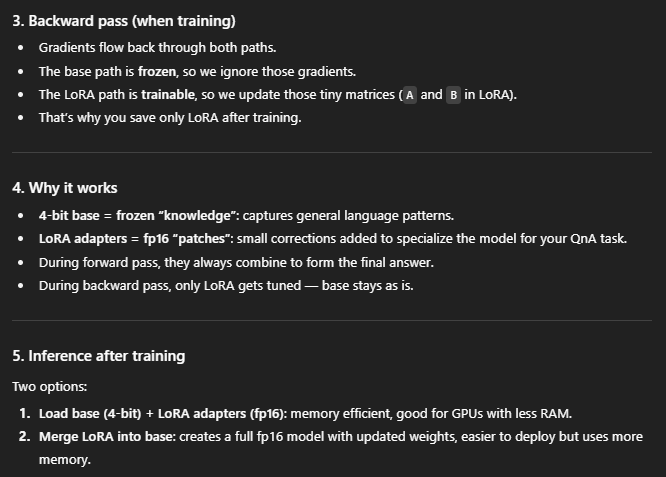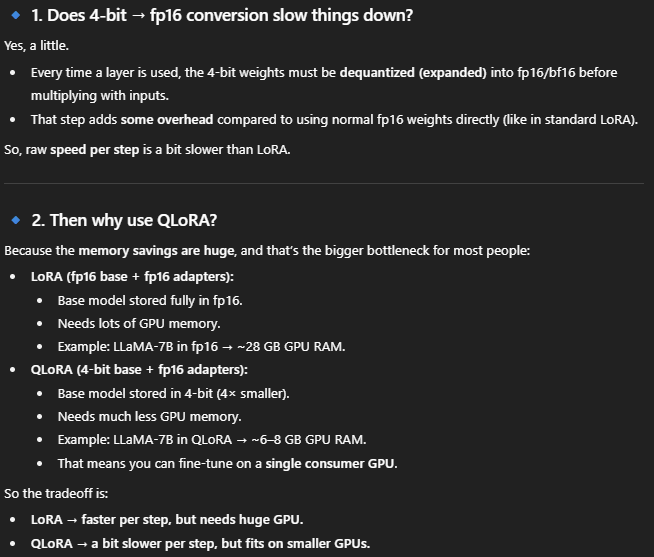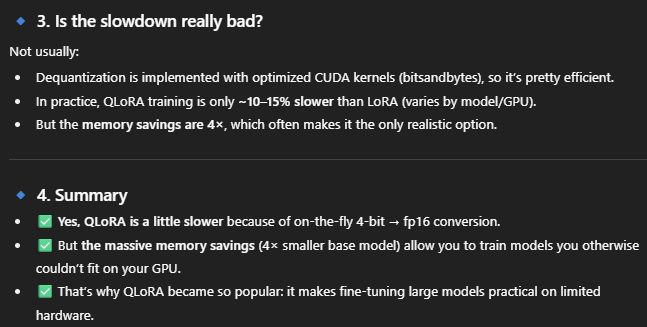

### fp16 vs bfloat16?
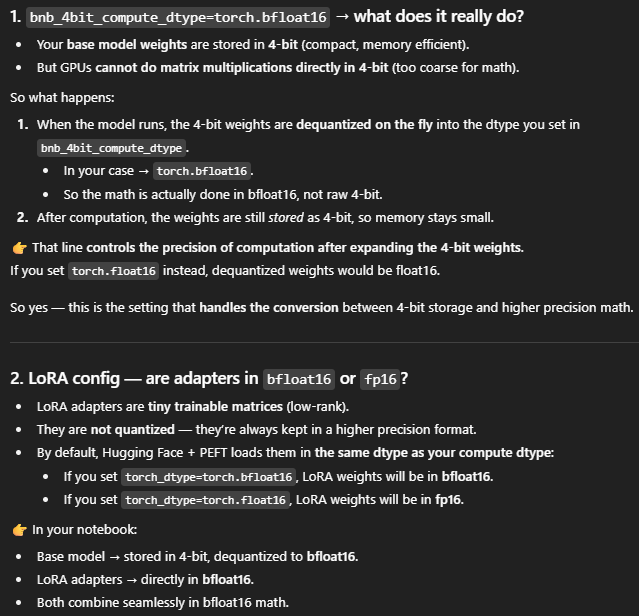
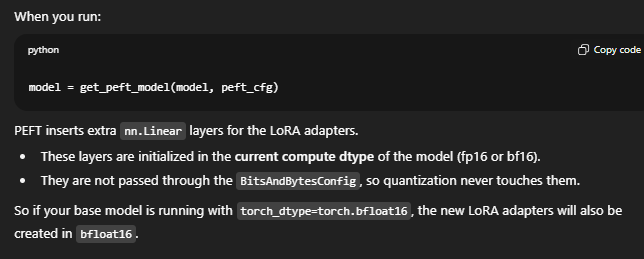

In [ ]:
# ---------------------------
# STEP 10: Load Base Model with 4-bit Quantization (QLoRA setup)
# ---------------------------

# Why this step?
# - LLaMA models are large and don't fit easily on a Colab/T4 GPU.
# - QLoRA uses 4-bit quantization to drastically reduce memory usage,
#   while still allowing fine-tuning via LoRA adapters.
# - This lets us fine-tune models like LLaMA-3B on consumer GPUs.


from transformers import AutoModelForCausalLM, BitsAndBytesConfig


# Configure 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,          # Enable 4-bit weights
    bnb_4bit_quant_type="nf4",  # NormalFloat4 for better precision
    bnb_4bit_compute_dtype=torch.bfloat16,  # Use bfloat16 for computation (efficient + stable)
    bnb_4bit_use_double_quant=True  # Nested quantization for extra memory savings
)

# Load quantized model
model = AutoModelForCausalLM.from_pretrained(
    local_model_dir,                        # load model files from Drive
    quantization_config=bnb_config,         # apply 4-bit quantization
    device_map="auto",                      # automatically map model to GPU
    torch_dtype=torch.bfloat16              # ensure computations use bfloat16
)

# Enable gradient checkpointing for memory efficiency
model.gradient_checkpointing_enable()
model.config.use_cache = False  # important for training

# Print model info
print(f"Model loaded from {local_model_dir} with 4-bit quantization")

Model loaded from /content/drive/MyDrive/LLM_training/HF_models/Llama-3.2-1B-Instruct with 4-bit quantization


### PEFT config:

In [ ]:
# ---------------------------
# STEP 11: Apply LoRA Adapters (PEFT Setup)
# ---------------------------

# Why this step?
# - Full fine-tuning of LLaMA requires huge GPU memory (not feasible on Colab/T4).
# - LoRA (Low-Rank Adaptation) adds small trainable matrices ("adapters")
#   to attention layers while keeping most of the base model frozen.
# - Combined with 4-bit quantization (QLoRA), this enables fine-tuning
#   large models efficiently on limited hardware.

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Prepare model for quantized training
model = prepare_model_for_kbit_training(
    model,
    use_gradient_checkpointing=True
)
model.config.use_cache = False  # Disable caching for training

# Configure LoRA
peft_cfg = LoraConfig(
    r=16,                          # LoRA rank (low-rank dimension for adapter matrices)
    lora_alpha=32,                 # Scaling factor for LoRA updates
    lora_dropout=0.05,             # Dropout applied on LoRA layers (helps generalization)
    bias="none",                   # Do not train bias terms (saves memory)
    task_type="CAUSAL_LM",         # Task type: Causal Language Modeling
    target_modules=[               # Which layers to inject LoRA into (key for LLaMA)
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ]
)

# Apply LoRA
model = get_peft_model(model, peft_cfg)

# Set training mode
model.train()

# Print trainable parameters
model.print_trainable_parameters()

print("LoRA configuration applied to model")

trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039
LoRA configuration applied to model


In [ ]:
# Assumes train_ds / val_ds each have a single column: 'text'
assert "text" in train_dataset.column_names and "text" in eval_dataset.column_names, "Datasets must include a 'text' column."


In [ ]:
# OUT_DIR = "/content/drive/MyDrive/LLM_training/QuestionAnswer/training_backup/llama32-finqa-qlora"
OUT_DIR = "/content/drive/MyDrive/LLM_training/QuestionAnswer/training_backup/sep28_llama32-finqa-qlora"



In [ ]:
%load_ext tensorboard
%tensorboard --logdir "$OUT_DIR/runs"

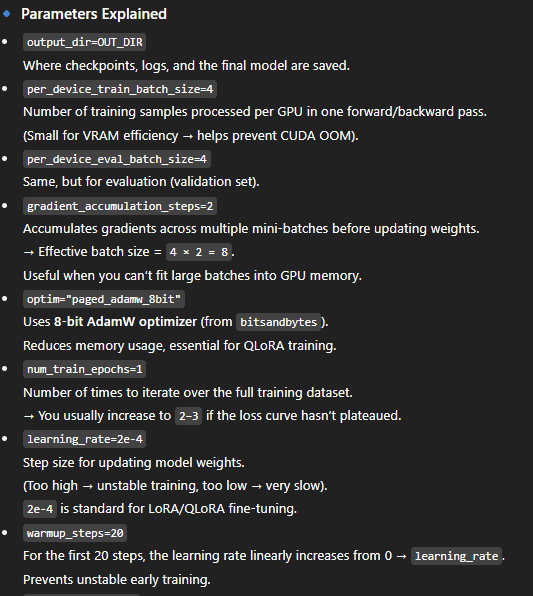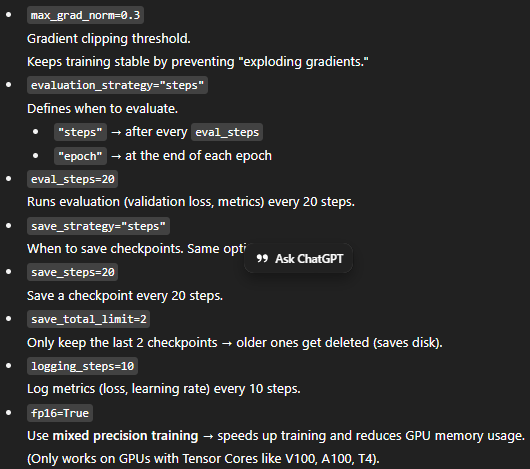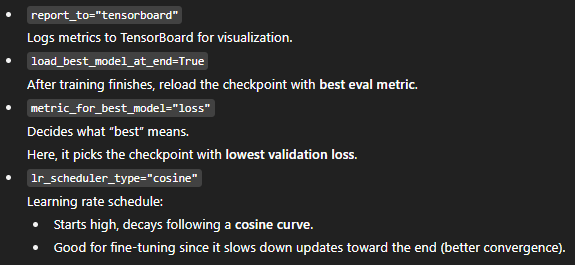

### SFTTrainer Parameters:
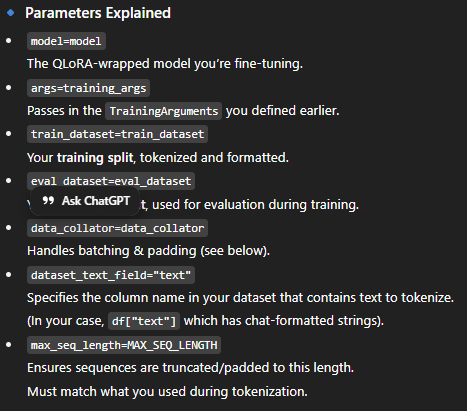

### What DataCollatorForLanguageModeling Does?

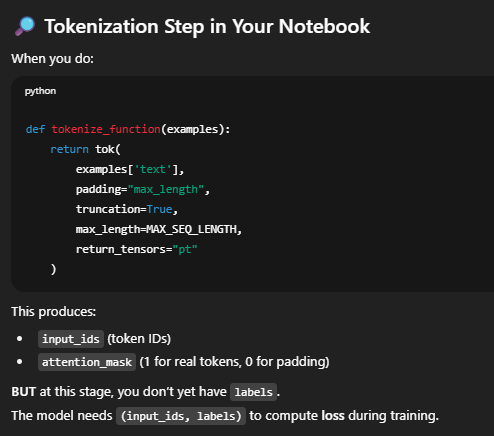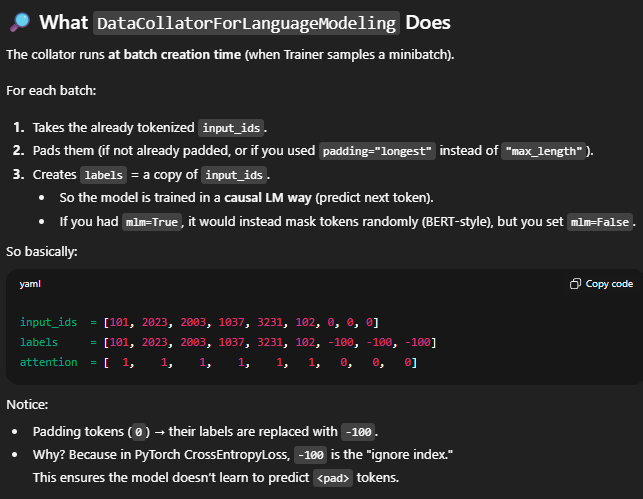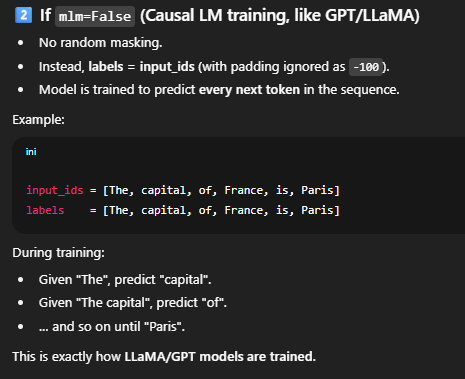

In [ ]:
# ---------------------------
# STEP 12: Define TrainingArguments & Run Training
# ---------------------------

# Why this step?
# - We need to configure how training happens (batch size, learning rate, optimizer, evaluation strategy, etc.)
# - Hugging Face's `TrainingArguments` controls training behavior
# - `trl.SFTTrainer` (Supervised Fine-Tuning Trainer) is specialized for chat/QnA fine-tuning

import os
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from trl import SFTTrainer
import torch

# Disable Accelerate mixed precision
os.environ["ACCELERATE_MIXED_PRECISION"] = "no"


# Define training arguments
training_args = TrainingArguments(
    output_dir=OUT_DIR,
    per_device_train_batch_size=4,  # As requested
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,  # Effective batch size of 8
    optim="paged_adamw_8bit",  # 8-bit optimizer
    num_train_epochs=1,  # Adjust to 2-3 if eval loss is high
    learning_rate=2e-4,  # Standard for LoRA
    warmup_steps=20,  # Gradual learning rate increase
    max_grad_norm=0.3,  # Gradient clipping
    evaluation_strategy="steps",
    eval_steps=20,  # Evaluate every 20 steps
    save_strategy="steps",
    save_steps=20,  # Save checkpoint every 500 steps
    save_total_limit=2,  # Keep last 2 checkpoints
    logging_steps=10,  # Log every 10 steps
    fp16=True,  # Mixed precision for T4 GPU
    report_to="tensorboard",  # Log to TensorBoard
    load_best_model_at_end=True,  # Load best model based on eval loss
    metric_for_best_model="loss",
    lr_scheduler_type="cosine"  # Cosine annealing
)

# Data collator for causal LM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tok,
    mlm=False
)

# Initialize SFTTrainer
trainer = SFTTrainer(
    model=model,                              # QLoRA model with adapters
    args=training_args,                       # training config
    train_dataset=train_dataset,              # training data
    eval_dataset=eval_dataset,                # validation data
    data_collator=data_collator,              # handles batching/padding
    dataset_text_field="text",                # use "text" column from dataset
    max_seq_length=MAX_SEQ_LENGTH                       # must match tokenization length
)

# Start training
trainer.train()

print("Training completed")

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will over

Step,Training Loss,Validation Loss
20,1.452600,1.181108
40,1.048700,1.096246
60,1.002800,0.958612
80,0.944000,0.934545
100,1.010700,0.916824
120,0.898300,0.911233
140,0.994000,0.907915
160,0.942700,0.903796
180,0.884500,0.895198
200,0.851000,0.891322


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an except

Training completed


### Resume Training

In [ ]:
# # ---------------------------
# # STEP 13: Resume Training from Last Checkpoint
# # ---------------------------

# # Why this step?
# # - Training large models may be interrupted (Colab runtime disconnects, etc.).
# # - Hugging Face Trainer supports checkpointing → we can resume instead of restarting.
# # - This saves time and ensures training continuity.

# ### resume

# import os
# from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
# from trl import SFTTrainer
# import torch

# # Disable Accelerate mixed precision
# os.environ["ACCELERATE_MIXED_PRECISION"] = "no"

# # Define output directory
# # OUT_DIR = "/content/drive/MyDrive/LLM_training/QuestionAnswer/training_backup/llama32-finqa-qlora"

# # Find latest checkpoint
# checkpoints = [os.path.join(OUT_DIR, d) for d in os.listdir(OUT_DIR) if d.startswith("checkpoint-")]
# latest_checkpoint = max(checkpoints, key=os.path.getmtime, default=None) if checkpoints else None

# ###################3

# # Define training arguments
# training_args = TrainingArguments(
#     output_dir=OUT_DIR,
#     per_device_train_batch_size=4,  # As requested
#     per_device_eval_batch_size=4,
#     gradient_accumulation_steps=2,  # Effective batch size of 8
#     optim="paged_adamw_8bit",  # 8-bit optimizer
#     num_train_epochs=1,  # Adjust to 2-3 if eval loss is high
#     learning_rate=2e-4,  # Standard for LoRA
#     warmup_steps=20,  # Gradual learning rate increase
#     max_grad_norm=0.3,  # Gradient clipping
#     evaluation_strategy="steps",
#     eval_steps=20,  # Evaluate every 20 steps
#     save_strategy="steps",
#     save_steps=20,  # Save checkpoint every 500 steps
#     save_total_limit=2,  # Keep last 2 checkpoints
#     logging_steps=10,  # Log every 10 steps
#     fp16=True,  # Mixed precision for T4 GPU
#     report_to="tensorboard",  # Log to TensorBoard
#     load_best_model_at_end=True,  # Load best model based on eval loss
#     metric_for_best_model="loss",
#     lr_scheduler_type="cosine",  # Cosine annealing
#     resume_from_checkpoint=latest_checkpoint  # Resume from latest checkpoint

# )

# # Data collator for causal LM
# data_collator = DataCollatorForLanguageModeling(
#     tokenizer=tok,
#     mlm=False
# )

# # Initialize SFTTrainer
# trainer = SFTTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     data_collator=data_collator,
#     dataset_text_field="text",
#     max_seq_length=MAX_SEQ_LENGTH  # Match tokenization
# )

# # Start training
# trainer.train(resume_from_checkpoint=latest_checkpoint)


# print("Training completed")

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will over

Step,Training Loss,Validation Loss


Training completed


### Save Trained LoRA Adapters + Tokenizer

In [ ]:
# ---------------------------
# STEP 14: Save Trained LoRA Adapters + Tokenizer
# ---------------------------

# Why this step?
# - After fine-tuning with QLoRA, the model consists of:
#     1) Base model weights (frozen, not saved again)
#     2) LoRA adapters (small trainable matrices we just trained)
# - We need to save these adapters + tokenizer for future use.
# - This allows us to reload the fine-tuned model later, without retraining.

# Define save path
save_path = "/content/drive/MyDrive/LLM_training/QuestionAnswer/training_backup/save_model/Modelx_Qlora_Sep28"

# Create save directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save LoRA adapters
trainer.model.save_pretrained(save_path)

# Save tokenizer (use trainer.tokenizer if available, else fall back to tok)
if hasattr(trainer, 'tokenizer') and trainer.tokenizer is not None:
    trainer.tokenizer.save_pretrained(save_path)
    print("tokenizer from trainer saved.")
else:
    tok.save_pretrained(save_path)

# Save trainer state for resuming training
trainer.save_state()

tokenizer from trainer saved.


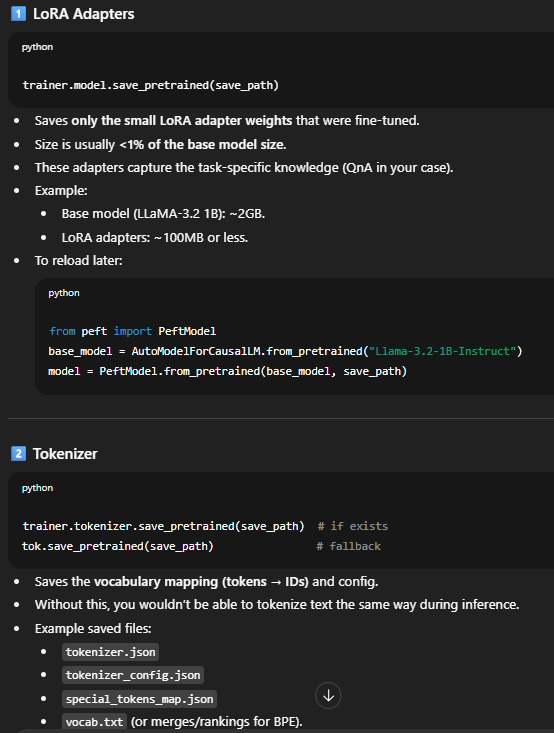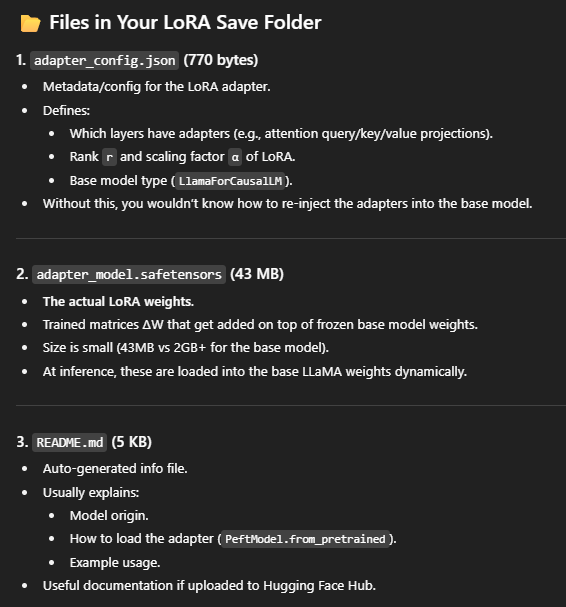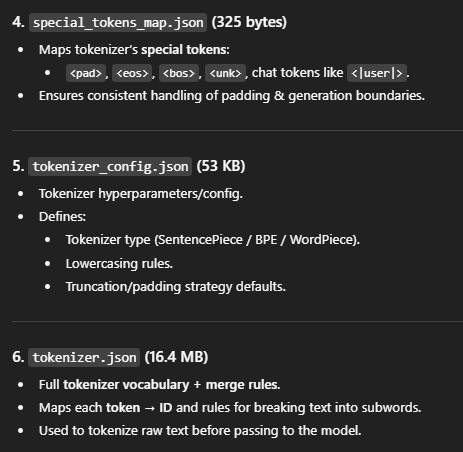

## Inference:

### using base model(Llama-3.2-1B-Instruct) and lora adaptors separately

In [ ]:
# ---------------------------
# STEP 15: Load Fine-Tuned Model (Base + LoRA) for Inference
# ---------------------------

# Why this step?
# - After training, we saved only the LoRA adapters (small, efficient).
# - For inference, we need to:
#     1) Reload the original base model (frozen)
#     2) Apply the LoRA adapters
# - This gives us the fine-tuned model ready for QnA.

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Define paths
save_path = "/content/drive/MyDrive/LLM_training/QuestionAnswer/training_backup/save_model/Modelx_Qlora_Sep28"
MODEL_ID = "meta-llama/Llama-3.2-1B-Instruct"
local_model_dir = f"/content/drive/MyDrive/LLM_training/HF_models/{MODEL_ID.split('/')[-1]}"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(save_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load base model and apply LoRA adapters
base_model = AutoModelForCausalLM.from_pretrained(
    local_model_dir,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
model = PeftModel.from_pretrained(base_model, save_path)
model.eval()

# Sample financial QA prompt in messages format
sample_prompt = [
    {"role": "system", "content": "You are a helpful financial assistant. Answer strictly from the provided context. If the answer is not present in the context, reply: 'I don't know.'"},
    {"role": "user", "content": "Context: Since our original focus on PC graphics, we have expanded into AI, gaming, and autonomous vehicles. Our GPUs are used in data centers for machine learning.\n\nQuestion: What area did NVIDIA initially focus on before expanding into other fields?"}
]

# Format prompt and tokenize
prompt = tokenizer.apply_chat_template(sample_prompt, tokenize=False)
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

# Perform inference
outputs = model.generate(
    **inputs,
    max_new_tokens=100,
    pad_token_id=tokenizer.eos_token_id
)
prediction = tokenizer.decode(outputs[0], skip_special_tokens=False)

# Print results
print("\n=== Inference Result ===")
print(f"Prompt: {prompt}")
print(f"Prediction: {prediction}")

print("Inference completed")

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)



=== Inference Result ===
Prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 28 Sep 2025

You are a helpful financial assistant. Answer strictly from the provided context. If the answer is not present in the context, reply: 'I don't know.'<|eot_id|><|start_header_id|>user<|end_header_id|>

Context: Since our original focus on PC graphics, we have expanded into AI, gaming, and autonomous vehicles. Our GPUs are used in data centers for machine learning.

Question: What area did NVIDIA initially focus on before expanding into other fields?<|eot_id|>
Prediction: <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 28 Sep 2025

You are a helpful financial assistant. Answer strictly from the provided context. If the answer is not present in the context, reply: 'I don't know.'<|eot_id|><|start_header_id|>user<|end_header_id|>

Context: Since our origin

In [ ]:
### Quantized version of model while inference

### Using merged (base + lora adaptors) in a standalone hf model

In [ ]:
# ---------------------------
# STEP 16: Merge LoRA Adapters into Base Model (Standalone Export)
# ---------------------------

# Why this step?
# - Until now, inference required:
#     1) Loading base model
#     2) Loading LoRA adapters separately
# - This is fine for training/dev, but inconvenient for deployment.
# - `merge_and_unload()` permanently fuses LoRA weights into the base model,
#   creating a *standalone* fine-tuned model you can share or use directly.

import os
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Define paths
save_path = "/content/drive/MyDrive/LLM_training/QuestionAnswer/training_backup/save_model/Modelx_Qlora_Sep28"
standalone_save_path = "/content/drive/MyDrive/LLM_training/QuestionAnswer/training_backup/save_model/Modelx_Qlora_Sep28_standAlone"
MODEL_ID = "meta-llama/Llama-3.2-1B-Instruct"
local_model_dir = f"/content/drive/MyDrive/LLM_training/HF_models/{MODEL_ID.split('/')[-1]}"

# Create standalone save directory if it doesn't exist
os.makedirs(standalone_save_path, exist_ok=True)

# Load tokenizer from save_path
tokenizer = AutoTokenizer.from_pretrained(save_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    local_model_dir,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

# Load LoRA adapters and merge with base model
merged_model = PeftModel.from_pretrained(base_model, save_path)
merged_model = merged_model.merge_and_unload() ### the standalone model you saved is in bfloat16.

# Save merged model and tokenizer
merged_model.save_pretrained(standalone_save_path)
tokenizer.save_pretrained(standalone_save_path)

print(f"Standalone merged model and tokenizer saved to {standalone_save_path}")

Standalone merged model and tokenizer saved to /content/drive/MyDrive/LLM_training/QuestionAnswer/training_backup/save_model/Modelx_Qlora_Sep28_standAlone


In [ ]:
# ---------------------------
# STEP 17: Inference with Standalone Fine-Tuned Model
# ---------------------------

# Why this step?
# - Now that we merged LoRA adapters into the base model (Step 16),
#   we can run inference with a *single standalone model*.
# - No need to separately load LoRA adapters anymore.
# - This version is easier for deployment and sharing (plug-and-play Hugging Face model).

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Define path to standalone model
standalone_save_path = "/content/drive/MyDrive/LLM_training/QuestionAnswer/training_backup/save_model/Modelx_Qlora_Sep28_standAlone"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(standalone_save_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load standalone merged model
model = AutoModelForCausalLM.from_pretrained(
    standalone_save_path,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
model.eval()

# Sample financial QA prompt in messages format
sample_prompt = [
    {"role": "system", "content": "You are a helpful financial assistant. Answer strictly from the provided context. If the answer is not present in the context, reply: 'I don't know.'"},
    {"role": "user", "content": "Context: Since our original focus on PC graphics, we have expanded into AI, gaming, and autonomous vehicles. Our GPUs are used in data centers for machine learning.\n\nQuestion: What area did NVIDIA initially focus on before expanding into other fields?"}
]

# Format prompt and tokenize
prompt = tokenizer.apply_chat_template(sample_prompt, tokenize=False)
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

# Perform inference
outputs = model.generate(
    **inputs,
    max_new_tokens=100,
    pad_token_id=tokenizer.eos_token_id
)
prediction = tokenizer.decode(outputs[0], skip_special_tokens=False)

# Print results
print("\n=== Inference Result ===")
print(f"Prompt: {prompt}")
print(f"Prediction: {prediction}")

print("Inference completed")


=== Inference Result ===
Prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 28 Sep 2025

You are a helpful financial assistant. Answer strictly from the provided context. If the answer is not present in the context, reply: 'I don't know.'<|eot_id|><|start_header_id|>user<|end_header_id|>

Context: Since our original focus on PC graphics, we have expanded into AI, gaming, and autonomous vehicles. Our GPUs are used in data centers for machine learning.

Question: What area did NVIDIA initially focus on before expanding into other fields?<|eot_id|>
Prediction: <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 28 Sep 2025

You are a helpful financial assistant. Answer strictly from the provided context. If the answer is not present in the context, reply: 'I don't know.'<|eot_id|><|start_header_id|>user<|end_header_id|>

Context: Since our origin

## Evaluation:

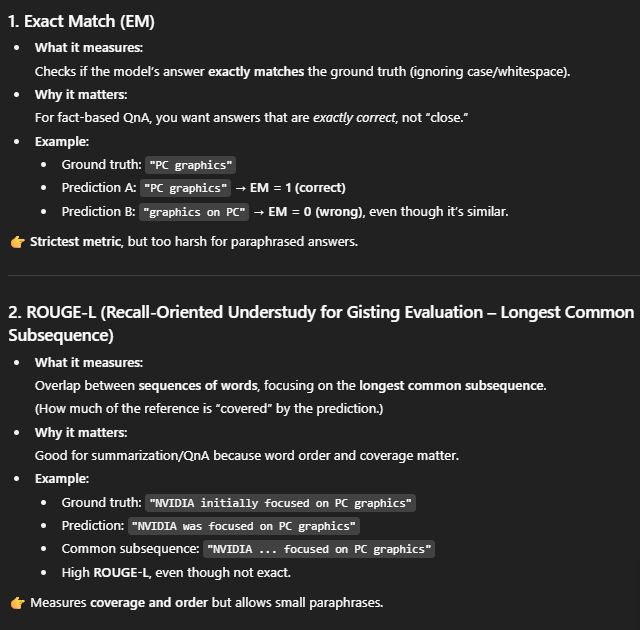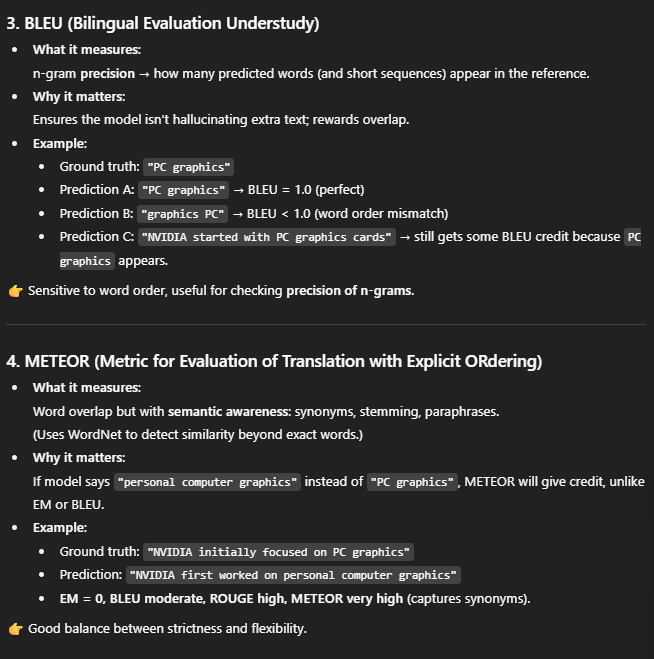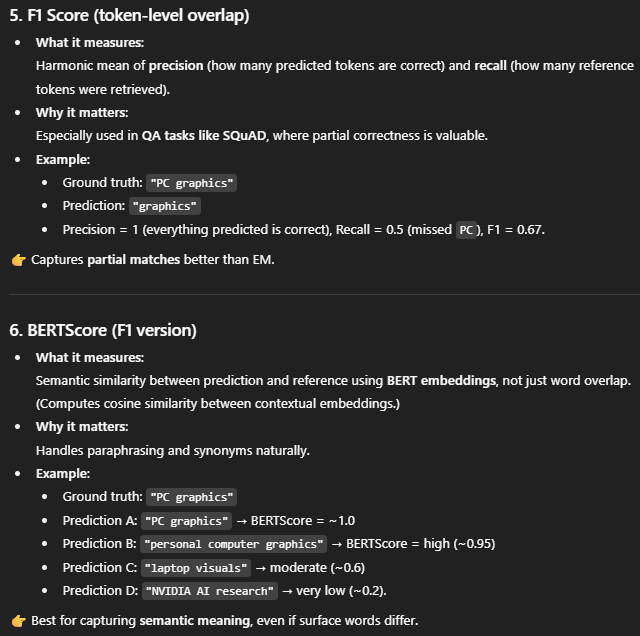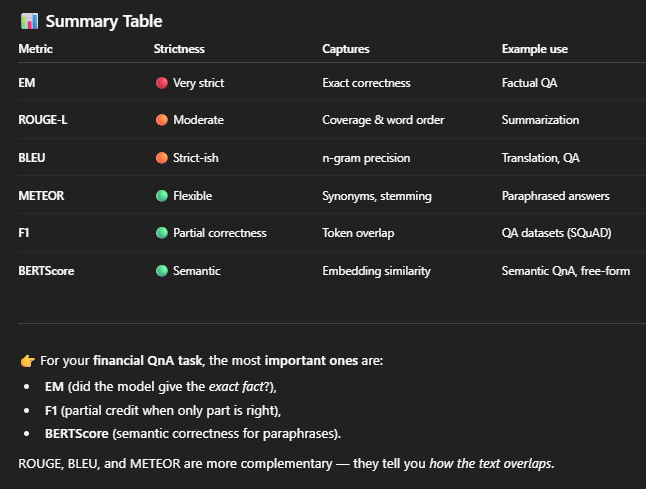

In [ ]:
# ---------------------------
# STEP 18: Compute Evaluation Metrics (with Base vs Fine-tuned Comparison )
# ---------------------------

import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from sklearn.metrics import precision_recall_fscore_support
import nltk
from bert_score import score as bert_score

# Download NLTK data for METEOR
nltk.download('wordnet')
nltk.download('omw-1.4')

# Clear GPU memory
torch.cuda.empty_cache()

# Define paths
standalone_save_path = "/content/drive/MyDrive/LLM_training/QuestionAnswer/training_backup/save_model/Modelx_Qlora_Sep28_standAlone"
base_model_dir = "/content/drive/MyDrive/LLM_training/HF_models/Llama-3.2-1B-Instruct"
excel_output_path = "/content/drive/MyDrive/LLM_training/QuestionAnswer/training_backup/eval_results_metrics.xlsx"

# Load tokenizer (same for both models)
tokenizer = AutoTokenizer.from_pretrained(standalone_save_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load fine-tuned standalone model
ft_model = AutoModelForCausalLM.from_pretrained(
    standalone_save_path,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
ft_model.eval()

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_dir,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
base_model.eval()

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# Prepare results list
results = []

# For BERTScore later
bert_refs = []
bert_ft_preds = []
bert_base_preds = []

# Iterate over eval_dataset
for sample in tqdm(eval_dataset, desc="Generating predictions"):
    text = sample['text']

    # ---- Extract user input ----
    user_start = text.find("<|start_header_id|>user<|end_header_id|>") + len("<|start_header_id|>user<|end_header_id|>")
    user_end = text.find("<|eot_id|>", user_start)
    user_text = text[user_start:user_end].strip() if user_end != -1 else text[user_start:].strip()

    context_query_split = user_text.split("\n\nQuestion:")
    if len(context_query_split) < 2:
        context, user_query = user_text, "N/A"
    else:
        context = context_query_split[0].replace("Context: ", "").strip()
        user_query = context_query_split[1].strip()

    # ---- Extract actual assistant response ----
    input_end = text.rfind("<|start_header_id|>assistant<|end_header_id|>")
    if input_end == -1:
        input_prompt, actual_text = text, "N/A"
    else:
        input_prompt = text[:input_end]
        actual_start = input_end + len("<|start_header_id|>assistant<|end_header_id|>")
        actual_end = text.rfind("<|eot_id|>", actual_start)
        actual_text = text[actual_start:actual_end].strip() if actual_end != -1 else text[actual_start:].strip()

    # ---- Tokenize input prompt ----
    inputs = tokenizer(input_prompt, return_tensors="pt").to("cuda")

    # ---- Fine-tuned prediction ----
    ft_outputs = ft_model.generate(
        **inputs,
        max_new_tokens=MAX_SEQ_LENGTH,
        pad_token_id=tokenizer.eos_token_id
    )
    ft_full = tokenizer.decode(ft_outputs[0], skip_special_tokens=False)
    ft_start = ft_full.rfind("<|start_header_id|>assistant<|end_header_id|>") + len("<|start_header_id|>assistant<|end_header_id|>")
    ft_end = ft_full.rfind("<|eot_id|>", ft_start)
    prediction = ft_full[ft_start:ft_end].strip() if ft_end != -1 else ft_full[ft_start:].strip()

    # ---- Base model prediction ----
    base_outputs = base_model.generate(
        **inputs,
        max_new_tokens=MAX_SEQ_LENGTH,
        pad_token_id=tokenizer.eos_token_id
    )
    base_full = tokenizer.decode(base_outputs[0], skip_special_tokens=False)
    base_start = base_full.rfind("<|start_header_id|>assistant<|end_header_id|>") + len("<|start_header_id|>assistant<|end_header_id|>")
    base_end = base_full.rfind("<|eot_id|>", base_start)
    base_prediction = base_full[base_start:base_end].strip() if base_end != -1 else base_full[base_start:].strip()

    # ---- Metrics for fine-tuned model ----
    em_ft = 1 if prediction.lower().strip() == actual_text.lower().strip() else 0
    rouge_ft = scorer.score(actual_text, prediction)['rougeL'].fmeasure
    bleu_ft = sentence_bleu([actual_text.split()], prediction.split(), weights=(0.25, 0.25, 0.25, 0.25))
    meteor_ft = meteor_score([actual_text.split()], prediction.split())

    # F1 (token-level overlap)
    gold_tokens, pred_tokens_ft = set(actual_text.split()), set(prediction.split())
    tp_ft = len(gold_tokens & pred_tokens_ft)
    precision_ft = tp_ft / len(pred_tokens_ft) if pred_tokens_ft else 0
    recall_ft = tp_ft / len(gold_tokens) if gold_tokens else 0
    f1_ft = 2 * precision_ft * recall_ft / (precision_ft + recall_ft) if (precision_ft + recall_ft) > 0 else 0

    # ---- Metrics for base model ----
    em_base = 1 if base_prediction.lower().strip() == actual_text.lower().strip() else 0
    rouge_base = scorer.score(actual_text, base_prediction)['rougeL'].fmeasure
    bleu_base = sentence_bleu([actual_text.split()], base_prediction.split(), weights=(0.25, 0.25, 0.25, 0.25))
    meteor_base = meteor_score([actual_text.split()], base_prediction.split())

    # F1 (token-level overlap)
    pred_tokens_base = set(base_prediction.split())
    tp_base = len(gold_tokens & pred_tokens_base)
    precision_base = tp_base / len(pred_tokens_base) if pred_tokens_base else 0
    recall_base = tp_base / len(gold_tokens) if gold_tokens else 0
    f1_base = 2 * precision_base * recall_base / (precision_base + recall_base) if (precision_base + recall_base) > 0 else 0

    # Collect for BERTScore
    bert_refs.append(actual_text)
    bert_ft_preds.append(prediction)
    bert_base_preds.append(base_prediction)

    # ---- Store results ----
    results.append({
        "Context": context,
        "User Query": user_query,
        "Prediction": prediction,
        "BaseModel_Prediction": base_prediction,
        "Actual Text": actual_text,
        "Exact Match (FT)": em_ft,
        "Exact Match (Base)": em_base,

        "ROUGE-L (FT)": rouge_ft,
        "ROUGE-L (Base)": rouge_base,

        "BLEU (FT)": bleu_ft,
        "BLEU (Base)": bleu_base,

        "METEOR (FT)": meteor_ft,
        "METEOR (Base)": meteor_base,

        "F1 (FT)": f1_ft,
        "F1 (Base)": f1_base
    })

# ---- Compute BERTScore (batch for efficiency) ----
P_ft, R_ft, F1_ft = bert_score(bert_ft_preds, bert_refs, lang="en", verbose=True)
P_base, R_base, F1_base = bert_score(bert_base_preds, bert_refs, lang="en", verbose=True)

# Add BERTScore results to DataFrame
for i in range(len(results)):
    results[i]["BERTScore-F1 (FT)"] = F1_ft[i].item()
    results[i]["BERTScore-F1 (Base)"] = F1_base[i].item()

# Save results
df_results = pd.DataFrame(results)
df_results.to_excel(excel_output_path, index=False)

# Overall metrics
print("\n=== Overall Metrics (Fine-tuned) ===")
print(f"Exact Match: {df_results['Exact Match (FT)'].mean():.2%}")
print(f"ROUGE-L: {df_results['ROUGE-L (FT)'].mean():.4f}")
print(f"BLEU: {df_results['BLEU (FT)'].mean():.4f}")
print(f"METEOR: {df_results['METEOR (FT)'].mean():.4f}")
print(f"F1: {df_results['F1 (FT)'].mean():.4f}")
print(f"BERTScore-F1: {df_results['BERTScore-F1 (FT)'].mean():.4f}")

print("\n=== Overall Metrics (Base Model) ===")
print(f"Exact Match: {df_results['Exact Match (Base)'].mean():.2%}")
print(f"ROUGE-L: {df_results['ROUGE-L (Base)'].mean():.4f}")
print(f"BLEU: {df_results['BLEU (Base)'].mean():.4f}")
print(f"METEOR: {df_results['METEOR (Base)'].mean():.4f}")
print(f"F1: {df_results['F1 (Base)'].mean():.4f}")
print(f"BERTScore-F1: {df_results['BERTScore-F1 (Base)'].mean():.4f}")

# Preview
print("\n=== Sample Predictions (Base vs Fine-tuned) ===")
for i in range(min(3, len(results))):
    print(f"\nSample {i+1}:")
    print(f"User Query: {results[i]['User Query']}")
    print(f"Context: {results[i]['Context'][:100]}...")
    print(f"Base Prediction: {results[i]['BaseModel_Prediction']}")
    print(f"Fine-tuned Prediction: {results[i]['Prediction']}")
    print(f"Actual: {results[i]['Actual Text']}")
    print(f"EM (Base): {results[i]['Exact Match (Base)']}, ROUGE-L (Base): {results[i]['ROUGE-L (Base)']:.4f}, BLEU (Base): {results[i]['BLEU (Base)']:.4f}, METEOR (Base): {results[i]['METEOR (Base)']:.4f}, F1 (Base): {results[i]['F1 (Base)']:.4f}, BERTScore-F1 (Base): {results[i]['BERTScore-F1 (Base)']:.4f}")
    print(f"EM (FT): {results[i]['Exact Match (FT)']}, ROUGE-L (FT): {results[i]['ROUGE-L (FT)']:.4f}, BLEU (FT): {results[i]['BLEU (FT)']:.4f}, METEOR (FT): {results[i]['METEOR (FT)']:.4f}, F1 (FT): {results[i]['F1 (FT)']:.4f}, BERTScore-F1 (FT): {results[i]['BERTScore-F1 (FT)']:.4f}")

torch.cuda.empty_cache()
print(f"\n✅ Results with base vs fine-tuned metrics (incl. F1 & BERTScore) saved to {excel_output_path}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
Generating predictions:   0%|          | 0/1750 [00:00<?, ?it/s]Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/53 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/28 [00:00<?, ?it/s]

done in 30.85 seconds, 56.72 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/39 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/28 [00:00<?, ?it/s]

done in 26.21 seconds, 66.77 sentences/sec

=== Overall Metrics (Fine-tuned) ===
Exact Match: 3.89%
ROUGE-L: 0.4935
BLEU: 0.1947
METEOR: 0.5149
F1: 0.4953
BERTScore-F1: 0.9163

=== Overall Metrics (Base Model) ===
Exact Match: 0.17%
ROUGE-L: 0.1569
BLEU: 0.0567
METEOR: 0.1832
F1: 0.1568
BERTScore-F1: 0.8414

=== Sample Predictions (Base vs Fine-tuned) ===

Sample 1:
User Query: How much were the company's debt obligations as of December 31, 2023?
Context: The company's debt obligations as of December 31, 2023, totaled $2,299,887 thousand....
Base Prediction: I don't know.
Fine-tuned Prediction: $2,299,887 thousand.
Actual: $2,299,887 thousand
EM (Base): 0, ROUGE-L (Base): 0.0000, BLEU (Base): 0.0000, METEOR (Base): 0.0000, F1 (Base): 0.0000, BERTScore-F1 (Base): 0.7694
EM (FT): 0, ROUGE-L (FT): 1.0000, BLEU (FT): 0.0000, METEOR (FT): 0.2500, F1 (FT): 0.5000, BERTScore-F1 (FT): 0.9866

Sample 2:
User Query: What are the specific structures and legal considerations for a management servi

In [ ]:
# ---------------------------
# STEP 19: Load model as 4bit for inference for low capacity GPU )
# ---------------------------


import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import nltk
from bert_score import score as bert_score

# Download NLTK data for METEOR
nltk.download('wordnet')
nltk.download('omw-1.4')

# Clear GPU memory
torch.cuda.empty_cache()

# Define paths
standalone_save_path = "/content/drive/MyDrive/LLM_training/QuestionAnswer/training_backup/save_model/Modelx_Qlora_Sep28_standAlone"
base_model_dir = "/content/drive/MyDrive/LLM_training/HF_models/Llama-3.2-1B-Instruct"
excel_output_path = "/content/drive/MyDrive/LLM_training/QuestionAnswer/training_backup/eval_results_metrics.xlsx"

# Load tokenizer (same for both models)
tokenizer = AutoTokenizer.from_pretrained(standalone_save_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# BitsAndBytes 4-bit config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True
)

# Load fine-tuned standalone model in 4-bit
ft_model = AutoModelForCausalLM.from_pretrained(
    standalone_save_path,
    quantization_config=bnb_config,
    device_map="auto"
)
ft_model.eval()

# Load base model in 4-bit
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_dir,
    quantization_config=bnb_config,
    device_map="auto"
)
base_model.eval()

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# Prepare results list
results = []

# For BERTScore later
bert_refs, bert_ft_preds, bert_base_preds = [], [], []

# Iterate over eval_dataset
for sample in tqdm(eval_dataset, desc="Generating predictions"):
    text = sample['text']

    # ---- Extract user input ----
    user_start = text.find("<|start_header_id|>user<|end_header_id|>") + len("<|start_header_id|>user<|end_header_id|>")
    user_end = text.find("<|eot_id|>", user_start)
    user_text = text[user_start:user_end].strip() if user_end != -1 else text[user_start:].strip()

    context_query_split = user_text.split("\n\nQuestion:")
    if len(context_query_split) < 2:
        context, user_query = user_text, "N/A"
    else:
        context = context_query_split[0].replace("Context: ", "").strip()
        user_query = context_query_split[1].strip()

    # ---- Extract actual assistant response ----
    input_end = text.rfind("<|start_header_id|>assistant<|end_header_id|>")
    if input_end == -1:
        input_prompt, actual_text = text, "N/A"
    else:
        input_prompt = text[:input_end]
        actual_start = input_end + len("<|start_header_id|>assistant<|end_header_id|>")
        actual_end = text.rfind("<|eot_id|>", actual_start)
        actual_text = text[actual_start:actual_end].strip() if actual_end != -1 else text[actual_start:].strip()

    # ---- Tokenize input prompt ----
    inputs = tokenizer(input_prompt, return_tensors="pt").to("cuda")

    # ---- Fine-tuned prediction ----
    ft_outputs = ft_model.generate(
        **inputs,
        max_new_tokens=MAX_SEQ_LENGTH,
        pad_token_id=tokenizer.eos_token_id
    )
    ft_full = tokenizer.decode(ft_outputs[0], skip_special_tokens=False)
    ft_start = ft_full.rfind("<|start_header_id|>assistant<|end_header_id|>") + len("<|start_header_id|>assistant<|end_header_id|>")
    ft_end = ft_full.rfind("<|eot_id|>", ft_start)
    prediction = ft_full[ft_start:ft_end].strip() if ft_end != -1 else ft_full[ft_start:].strip()

    # ---- Base model prediction ----
    base_outputs = base_model.generate(
        **inputs,
        max_new_tokens=MAX_SEQ_LENGTH,
        pad_token_id=tokenizer.eos_token_id
    )
    base_full = tokenizer.decode(base_outputs[0], skip_special_tokens=False)
    base_start = base_full.rfind("<|start_header_id|>assistant<|end_header_id|>") + len("<|start_header_id|>assistant<|end_header_id|>")
    base_end = base_full.rfind("<|eot_id|>", base_start)
    base_prediction = base_full[base_start:base_end].strip() if base_end != -1 else base_full[base_start:].strip()

    # ---- Metrics for fine-tuned model ----
    em_ft = 1 if prediction.lower().strip() == actual_text.lower().strip() else 0
    rouge_ft = scorer.score(actual_text, prediction)['rougeL'].fmeasure
    bleu_ft = sentence_bleu([actual_text.split()], prediction.split(), weights=(0.25, 0.25, 0.25, 0.25))
    meteor_ft = meteor_score([actual_text.split()], prediction.split())

    gold_tokens, pred_tokens_ft = set(actual_text.split()), set(prediction.split())
    tp_ft = len(gold_tokens & pred_tokens_ft)
    precision_ft = tp_ft / len(pred_tokens_ft) if pred_tokens_ft else 0
    recall_ft = tp_ft / len(gold_tokens) if gold_tokens else 0
    f1_ft = 2 * precision_ft * recall_ft / (precision_ft + recall_ft) if (precision_ft + recall_ft) > 0 else 0

    # ---- Metrics for base model ----
    em_base = 1 if base_prediction.lower().strip() == actual_text.lower().strip() else 0
    rouge_base = scorer.score(actual_text, base_prediction)['rougeL'].fmeasure
    bleu_base = sentence_bleu([actual_text.split()], base_prediction.split(), weights=(0.25, 0.25, 0.25, 0.25))
    meteor_base = meteor_score([actual_text.split()], base_prediction.split())

    pred_tokens_base = set(base_prediction.split())
    tp_base = len(gold_tokens & pred_tokens_base)
    precision_base = tp_base / len(pred_tokens_base) if pred_tokens_base else 0
    recall_base = tp_base / len(gold_tokens) if gold_tokens else 0
    f1_base = 2 * precision_base * recall_base / (precision_base + recall_base) if (precision_base + recall_base) > 0 else 0

    # Collect for BERTScore
    bert_refs.append(actual_text)
    bert_ft_preds.append(prediction)
    bert_base_preds.append(base_prediction)

    # ---- Store results ----
    results.append({
        "Context": context,
        "User Query": user_query,
        "Prediction": prediction,
        "BaseModel_Prediction": base_prediction,
        "Actual Text": actual_text,
        "Exact Match (FT)": em_ft,
        "Exact Match (Base)": em_base,
        "ROUGE-L (FT)": rouge_ft,
        "ROUGE-L (Base)": rouge_base,
        "BLEU (FT)": bleu_ft,
        "BLEU (Base)": bleu_base,
        "METEOR (FT)": meteor_ft,
        "METEOR (Base)": meteor_base,
        "F1 (FT)": f1_ft,
        "F1 (Base)": f1_base
    })

# ---- Compute BERTScore (batch for efficiency) ----
P_ft, R_ft, F1_ft = bert_score(bert_ft_preds, bert_refs, lang="en", verbose=True)
P_base, R_base, F1_base = bert_score(bert_base_preds, bert_refs, lang="en", verbose=True)

# Add BERTScore results to DataFrame
for i in range(len(results)):
    results[i]["BERTScore-F1 (FT)"] = F1_ft[i].item()
    results[i]["BERTScore-F1 (Base)"] = F1_base[i].item()

# Save results
df_results = pd.DataFrame(results)
df_results.to_excel(excel_output_path, index=False)

print("\n✅ Results with base vs fine-tuned metrics (4-bit models) saved to", excel_output_path)


## To-do list

2.   deployment with .cpp or GGUF or any other kind of deployment



